# Regression Fundamentals: Beyond Linearity

In previous sessions, we learned how linear regression works: fit a
straight line to data, minimise prediction error, and use that line for
prediction and inference. Linear regression is powerful, but it assumes
relationships are linear. In reality, data often follows curves, has
constraints, or exhibits patterns that straight lines can’t capture.

This session explores how the linear regression framework is adapted to
non-linear patterns, using generalised linear models (GLMs), through
**link functions**. We’ll see that the same core idea, fitting a line
through data to describe the relationship between variables, works for
binary outcomes, counts, and other constrained data types. The key is
transforming the scale so linear models can work.

We’ll focus on **logistic regression** for binary outcomes, implement it
with real data, and briefly introduce other extensions like multilevel
models and GAMs.

# Slides

Use the left ⬅️ and right ➡️ arrow keys to navigate through the slides
below. To view in a separate tab/window,
<a href="slides.html" target="_blank">follow this link</a>.

## When Linear Regression Fails

Linear regression assumes the relationship between predictors and
outcome is linear. This works when each unit increase in $X$ produces a
constant change in $Y$. But many real-world relationships don’t follow
this pattern.

### Examples of Non-Linear Data

-   Binary outcomes - Survived/died, yes/no, pass/fail. Outcomes are 0
    or 1, not continuous.
-   Count data - Number of hospital visits, customer complaints. Must be
    non-negative integers.
-   Proportions - Percentage passing an exam, recovery rates. Bounded
    between 0 and 1.
-   Growth curves - Disease spread, population growth. Exponential or
    S-shaped patterns.

Forcing linear regression onto these data types produces nonsensical
predictions (probabilities above 1, negative counts) and violates model
assumptions.

## The Problem Illustrated

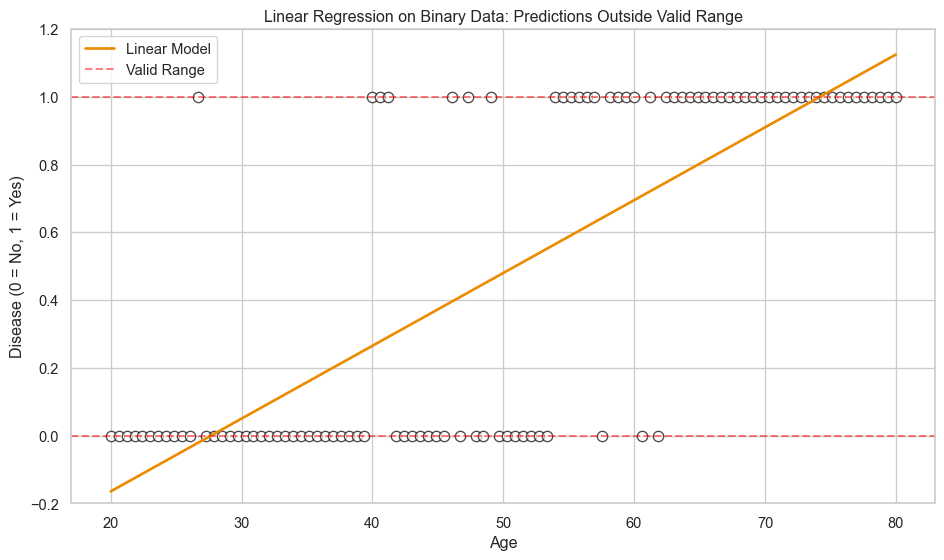

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression

# set visualisation style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# simulate binary outcome data
np.random.seed(42)
age = np.linspace(20, 80, 100)
prob_true = 1 / (1 + np.exp(-(age - 50) / 8))
disease = np.random.binomial(1, prob_true)

# fit linear regression
model_linear = LinearRegression()
model_linear.fit(age.reshape(-1, 1), disease)
pred_linear = model_linear.predict(age.reshape(-1, 1))

# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=age, y=disease, facecolors='white', edgecolors='black',
                s=60, linewidths=1, alpha=0.7, ax=ax)
sns.lineplot(x=age, y=pred_linear, color='#ED8B00', linewidth=2, ax=ax, label='Linear Model')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Valid Range')
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Disease (0 = No, 1 = Yes)')
ax.set_title('Linear Regression on Binary Data: Predictions Outside Valid Range')
ax.set_ylim(-0.2, 1.2)
ax.legend()
plt.tight_layout()
plt.show()

Linear regression predicts values below 0 and above 1, which make no
sense for binary outcomes.

## The Solution - Link Functions

Generalised linear models adapt the linear model framework to work with
non-linear data. Link functions transform the scale so that a linear
model fits the data. Instead of fitting a line directly to constrained
data, we:

1.  Transform the outcome to an unbounded scale
2.  Fit a linear model on the transformed scale
3.  Transform predictions back to the original scale

This preserves the linearity of the model while respecting data
constraints.

How Logistic Regression Works (Click to Expand)

### The Logit Link

For binary outcomes, we use the logit link, which models the log-odds.

$$
\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1X
$$

The left side of this equation is the log-odds for an outcome of
probability $p$. This can be any value from $-\infty$ to $+\infty$. This
is equivalent to the right side of the equation, which is the linear
predictor we have encountered in previous sessions.

To get probabilities, we transform back using the inverse logit.

$$
p = \frac{1}{1 + e^{-(\beta_0 + \beta_1X)}}
$$

This produces an S-shaped curve that stays between 0 and 1.

### Why Log-Odds?

Odds represent the ratio of success to failure: $\frac{p}{1-p}$. If
$p = 0.8$, odds are $\frac{0.8}{0.2} = 4$ (4 to 1 in favour). Taking the
log makes this unbounded:

-   $p = 0.5$ → odds = 1 → log-odds = 0
-   $p$ close to 0 → odds close to 0 → log-odds $\to -\infty$
-   $p$ close to 1 → odds $\to \infty$ → log-odds $\to +\infty$

Now we can fit a linear model on the log-odds scale.

## Logistic Regression in Practice

Let’s implement logistic regression using the Titanic dataset. Our goal
is to predict passenger survival based on characteristics like age, sex,
and passenger class.

### Load and Prepare Data

In [2]:
# load titanic data
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
titanic = pd.read_csv(url)

# select relevant columns and drop missing values
df = titanic[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']].dropna()

# convert sex to binary
df['Sex'] = (df['Sex'] == 'female').astype(int)

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head(10))

Dataset shape: (714, 5)

First few rows:
    Survived  Pclass  Sex   Age     Fare
0          0       3    0  22.0   7.2500
1          1       1    1  38.0  71.2833
2          1       3    1  26.0   7.9250
3          1       1    1  35.0  53.1000
4          0       3    0  35.0   8.0500
6          0       1    0  54.0  51.8625
7          0       3    0   2.0  21.0750
8          1       3    1  27.0  11.1333
9          1       2    1  14.0  30.0708
10         1       3    1   4.0  16.7000

Exploratory Data Analysis (Click to Expand)

Before modelling, examine the relationships between predictors and
survival.

In [3]:
# overall survival rate
survival_rate = df['Survived'].mean()
print(f"Overall survival rate: {survival_rate:.1%}")

# survival by sex
survival_sex = df.groupby('Sex')['Survived'].mean()
print("\nSurvival rate by sex:")
print(survival_sex.to_frame().rename(columns={'Survived': 'Survival Rate'}))

Overall survival rate: 40.6%

Survival rate by sex:
     Survival Rate
Sex               
0         0.205298
1         0.754789

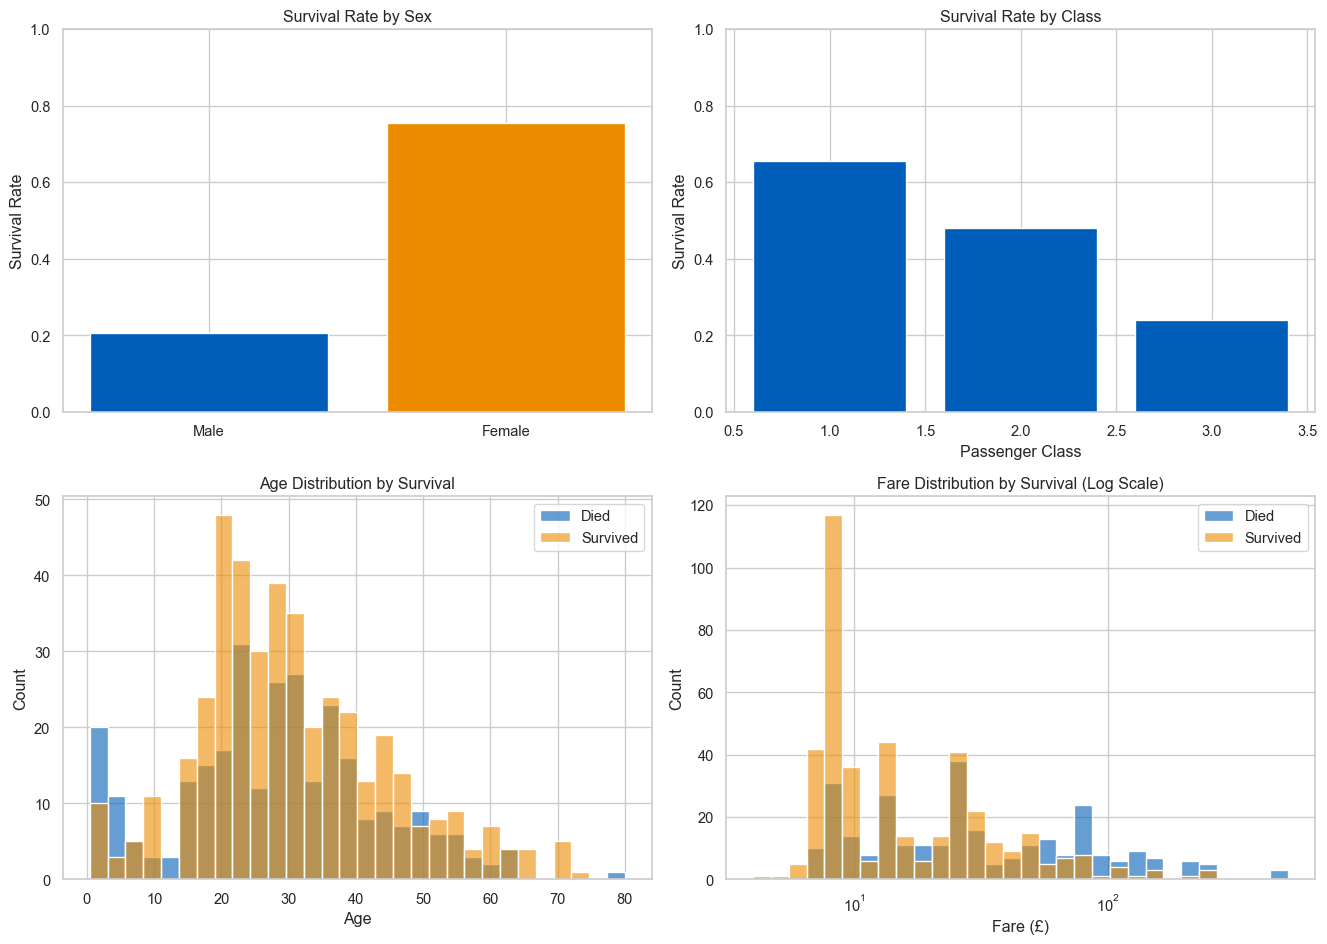

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# survival by sex
survival_sex = df.groupby('Sex')['Survived'].mean()
axes[0, 0].bar(['Male', 'Female'], survival_sex.values, color=['#005EB8', '#ED8B00'])
axes[0, 0].set_ylabel('Survival Rate')
axes[0, 0].set_title('Survival Rate by Sex')
axes[0, 0].set_ylim(0, 1)

# survival by class
survival_class = df.groupby('Pclass')['Survived'].mean()
axes[0, 1].bar(survival_class.index, survival_class.values, color='#005EB8')
axes[0, 1].set_xlabel('Passenger Class')
axes[0, 1].set_ylabel('Survival Rate')
axes[0, 1].set_title('Survival Rate by Class')
axes[0, 1].set_ylim(0, 1)

# age distribution by survival
sns.histplot(data=df, x='Age', hue='Survived', bins=30, ax=axes[1, 0], 
             palette={0: '#ED8B00', 1: '#005EB8'}, alpha=0.6)
axes[1, 0].set_title('Age Distribution by Survival')
axes[1, 0].set_xlabel('Age')
axes[1, 0].legend(['Died', 'Survived'])

# fare distribution by survival
sns.histplot(data=df, x='Fare', hue='Survived', bins=30, ax=axes[1, 1],
             palette={0: '#ED8B00', 1: '#005EB8'}, alpha=0.6, log_scale=True)
axes[1, 1].set_title('Fare Distribution by Survival (Log Scale)')
axes[1, 1].set_xlabel('Fare (£)')
axes[1, 1].legend(['Died', 'Survived'])

plt.tight_layout()
plt.show()

Women, first-class passengers, and children had higher survival rates.
Fare correlates with class.

### Fitting a Logistic Regression Model

We’ll fit two models: a simple model with only sex as a predictor, and a
multiple model with all predictors.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# prepare data
X = df[['Sex', 'Age', 'Pclass', 'Fare']]
y = df['Survived']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# fit logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

### Interpreting Coefficients

In [6]:
import statsmodels.api as sm

# use statsmodels for detailed output
X = sm.add_constant(X)
glm = sm.Logit(y, X).fit()

print(glm.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.453242
         Iterations 6
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4698      0.525      4.707      0.000       1.442       3.498
Sex            2.5182      0.208     12.115      0.000       2.111       2.926
Age           -0.0367      0.008     -4.780      0.000      -0.052      -0.022
Pclass        -1.2697      0.159     -8.005      0.000      -1.581      -0.959
Fare           0.0005      0.002      0.246      0.805      -0.004       0.005

Coefficients are on the log-odds scale. Positive coefficients increase
the probability of survival, negative coefficients decrease it.

-   Sex (Female) - Coefficient = 2.52. Being female increases log-odds
    of survival. On the probability scale, women had much higher
    survival rates.
-   Age - Coefficient = -0.037. Younger passengers had slightly higher
    survival rates.
-   Pclass - Coefficient = -1.27. Higher class numbers (lower class)
    decrease survival probability.
-   Fare - Coefficient = 0.001. Higher fares (correlated with class)
    increase survival.

### Converting Coefficients to Odds Ratios

Exponentiate coefficients to get **odds ratios**.

In [7]:
odds_ratios = np.exp(glm.params)
conf_int = np.exp(glm.conf_int())

results_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    '95% CI Lower': conf_int[0],
    '95% CI Upper': conf_int[1]
}).round(2)

print("\nOdds Ratios:")
print(results_df)


Odds Ratios:
        Odds Ratio  95% CI Lower  95% CI Upper
const        11.82          4.23         33.05
Sex          12.41          8.25         18.65
Age           0.96          0.95          0.98
Pclass        0.28          0.21          0.38
Fare          1.00          1.00          1.00

-   Sex - Being female multiplies the odds of survival by ~11. Women
    were much more likely to survive.
-   Age - Each year of age multiplies odds by ~0.97 (slight decrease).
-   Pclass - Each class decrease (e.g., 2nd to 3rd) multiplies odds by
    ~0.33.

### Making Predictions

In [8]:
# predict probabilities on test set
y_pred_prob = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

# model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.1%}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                   columns=['Predicted: Died', 'Predicted: Survived'],
                   index=['Actual: Died', 'Actual: Survived']))

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Died', 'Survived']))

Test set accuracy: 75.5%

Confusion Matrix:
                  Predicted: Died  Predicted: Survived
Actual: Died                   68                   19
Actual: Survived               16                   40

Classification Report:
              precision    recall  f1-score   support

        Died       0.81      0.78      0.80        87
    Survived       0.68      0.71      0.70        56

    accuracy                           0.76       143
   macro avg       0.74      0.75      0.75       143
weighted avg       0.76      0.76      0.76       143


The model correctly classifies ~76% of passengers. It performs better at
predicting deaths than survivals, likely because more passengers died
overall.

### Visualising Predictions

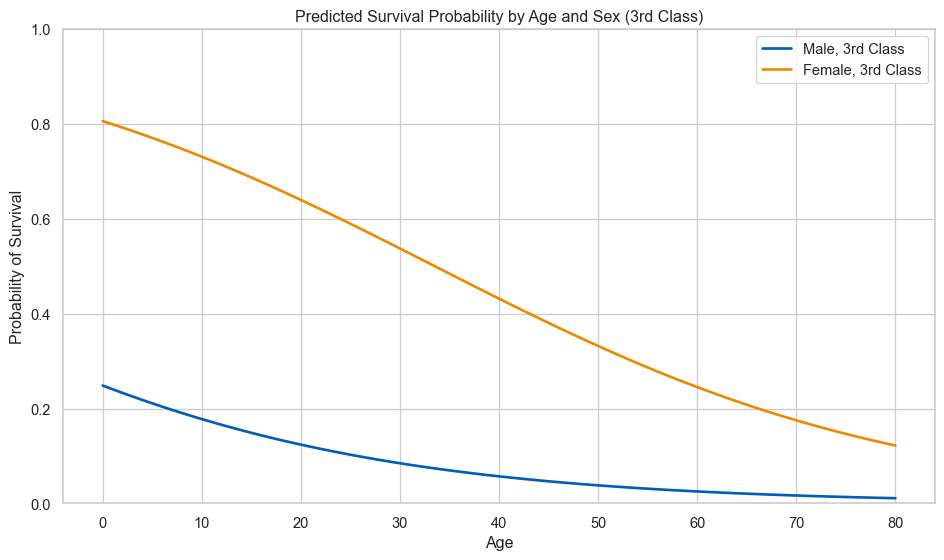

In [9]:
# create a grid of ages and predict survival probability for male/female passengers
age_range = np.linspace(0, 80, 100)

# predictions for male, 3rd class passengers
X_male = pd.DataFrame({
    'Sex': 0,
    'Age': age_range,
    'Pclass': 3,
    'Fare': df['Fare'].median()
})

# predictions for female, 3rd class passengers
X_female = pd.DataFrame({
    'Sex': 1,
    'Age': age_range,
    'Pclass': 3,
    'Fare': df['Fare'].median()
})

prob_male = clf.predict_proba(X_male)[:, 1]
prob_female = clf.predict_proba(X_female)[:, 1]

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=age_range, y=prob_male, color='#005EB8', linewidth=2, 
             label='Male, 3rd Class', ax=ax)
sns.lineplot(x=age_range, y=prob_female, color='#ED8B00', linewidth=2,
             label='Female, 3rd Class', ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Probability of Survival')
ax.set_title('Predicted Survival Probability by Age and Sex (3rd Class)')
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

Female passengers had much higher predicted survival probabilities
across all ages. Younger passengers (especially children) had higher
survival rates, consistent with “women and children first”.

## Other Extensions of Linear Regression

Logistic regression is just one example of adapting the linear framework
to non-linear data, but there are many ways this framework can be
extended.

### Poisson Regression for Count Data

When outcomes are counts (number of events, visits, occurrences),
Poisson regression uses a log link.

Model Formula (Click to Expand)

$$
\log(\text{E}[Y]) = \beta_0 + \beta_1X
$$

Transform back to get expected count:
$\text{E}[Y] = e^{\beta_0 + \beta_1X}$. Predictions are always positive,
matching count data.

Example use cases - Number of hospital admissions, customer complaints,
goals scored.

### Generalised Additive Models (GAMs)

GAMs fit smooth, flexible curves instead of straight lines.

Model Formula (Click to Expand)

$$
Y = \beta_0 + f_1(X_1) + f_2(X_2) + \epsilon
$$

Each $f_i(X_i)$ is a smooth function that adapts to the data. GAMs
capture complex non-linear patterns (U-shapes, wiggles) while remaining
interpretable.

Example use cases - Temperature effects on sales, age-related health
trends, non-linear dose-response relationships.

Python implementation uses `pygam`:

``` python
from pygam import GAM, s

# fit a GAM with smooth functions
gam = GAM(s(0) + s(1))
gam.fit(X, y)
```

### Multilevel Models

When data has hierarchical structure (students in schools, patients in
hospitals, repeated measures on individuals), multilevel models account
for grouping.

Model Formula (Click to Expand)

$$
Y_{ij} = \beta_0 + u_j + \beta_1X_{ij} + \epsilon_{ij}
$$

-   $u_j$ is a group-specific effect (random intercept).
-   Groups can have different baselines but share information.

Example use cases - Educational data (students in schools), clinical
trials (patients in sites), longitudinal data (repeated measures on
individuals).

Python implementation uses `statsmodels` or `pymer4`:

``` python
import statsmodels.formula.api as smf

# fit a multilevel model
mlm = smf.mixedlm("y ~ x", data=df, groups=df["group_id"])
result = mlm.fit()
```

### Survival Analysis

When modelling time until an event (death, failure, recovery), use
survival models like Cox proportional hazards regression. These account
for censoring (observations where the event hasn’t occurred yet).

Example use cases - Patient survival times, equipment failure, customer
churn.

## Why This Matters

All these models share the same foundation: linear regression. Once you
understand fitting a line to data, you can:

-   Use link functions for constrained outcomes (binary, counts,
    proportions)
-   Fit flexible curves with GAMs
-   Account for hierarchy with multilevel models
-   Model time-to-event data with survival analysis

The linear framework is incredibly versatile. It’s not just for linear
relationships.

## Summary

-   Real data often violates linear regression assumptions
-   Link functions transform data so linear models work
-   Logistic regression (logit link) handles binary outcomes
-   Other GLMs (Poisson, etc.) handle counts and constrained data
-   Extensions like GAMs and multilevel models add flexibility
-   The linear framework adapts to almost any problem

Linear regression isn’t just a starting point. It’s a foundation you can
build on for almost any modelling task.